In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import numpy as np
import random
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns

# from efficientnet_pytorch import EfficientNet

In [4]:
print(torch.cuda.is_available())

False


In [5]:
def torch_fix_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

In [6]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=[-90, 90]),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

batch_size = 8

dataset = ImageFolder(root='train_folder')

test_dataset = ImageFolder(root='test_folder', transform=data_transform['val'])
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'train_folder'

In [ ]:
print(len(dataset))
print(len(test_dataset))

140
100


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

best_model_accuracy = 0.0
best_acc_model = None
best_model_name = ""
best_model_loss = float('inf')
best_loss_model = None
best_model_name = ""

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    best_val_loss = float('inf')
    print(f'Fold {fold + 1}')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_subset.dataset.transform = data_transform['train']
    val_subset.dataset.transform = data_transform['val']

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)


    # example
    save_path = 'best_model.pth'
    pretrained_model = models.resnet101(pretrained=True)
    num_ftrs = pretrained_model.fc.in_features
    pretrained_model.fc = nn.Linear(num_ftrs, 2)


    parameters_to_update = pretrained_model.parameters()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pretrained_model = pretrained_model.to(device)

    optimizer = optim.Adam(parameters_to_update, lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 50
    early_stopping_patience = 10
    no_improvement_count = 0

    for epoch in range(num_epochs):
        pretrained_model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = pretrained_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions.double() / len(train_loader.dataset)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        pretrained_model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = pretrained_model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
            if best_val_loss < best_model_loss:
                best_model_loss = best_val_loss
                torch.save(pretrained_model.state_dict(), save_path)
        else:
            no_improvement_count += 1

        if no_improvement_count >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

Fold 1


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Loss: 0.4484 Acc: 0.7857
Validation Loss: 0.5274 Acc: 0.7857
Training Loss: 0.2599 Acc: 0.8750
Validation Loss: 0.3539 Acc: 0.8571
Training Loss: 0.2486 Acc: 0.8839
Validation Loss: 0.3246 Acc: 0.8929
Training Loss: 0.2083 Acc: 0.9018
Validation Loss: 0.2815 Acc: 0.8929
Training Loss: 0.0743 Acc: 0.9821
Validation Loss: 0.2370 Acc: 0.9286
Training Loss: 0.0239 Acc: 1.0000
Validation Loss: 0.3498 Acc: 0.8929
Training Loss: 0.0590 Acc: 0.9821
Validation Loss: 0.4008 Acc: 0.9286
Training Loss: 0.0217 Acc: 0.9911
Validation Loss: 0.4379 Acc: 0.8571
Training Loss: 0.0365 Acc: 0.9911
Validation Loss: 0.5240 Acc: 0.8929
Training Loss: 0.0181 Acc: 1.0000
Validation Loss: 0.5560 Acc: 0.8929
Training Loss: 0.0092 Acc: 1.0000
Validation Loss: 0.4897 Acc: 0.8571
Training Loss: 0.0265 Acc: 1.0000
Validation Loss: 0.2659 Acc: 0.8929
Training Loss: 0.0656 Acc: 0.9821
Validation Loss: 0.3942 Acc: 0.8929
Training Loss: 0.0706 Acc: 0.9821
Validation Loss: 0.7524 Acc: 0.7857
Training Loss: 0.042

In [ ]:
print(f'Best Accuracy: {best_model_accuracy:.4f}')
print(f'Best Loss: {best_model_loss:.4f}')

Best Accuracy: 0.0000
Best Loss: 0.1116


In [ ]:
y_true = []
y_pred = []
y_probs = []


best_loss_model = models.resnet101(pretrained=True)
num_ftrs = best_loss_model.fc.in_features
best_loss_model.fc = nn.Linear(num_ftrs, 2)

best_loss_model.to(device)
best_loss_model.load_state_dict(torch.load(save_path))

best_loss_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_loss_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        probabilities = nn.functional.softmax(outputs, dim=1)
        y_probs.extend(probabilities.cpu().numpy())

Confusion Matrix:
[[42  8]
 [ 1 49]]


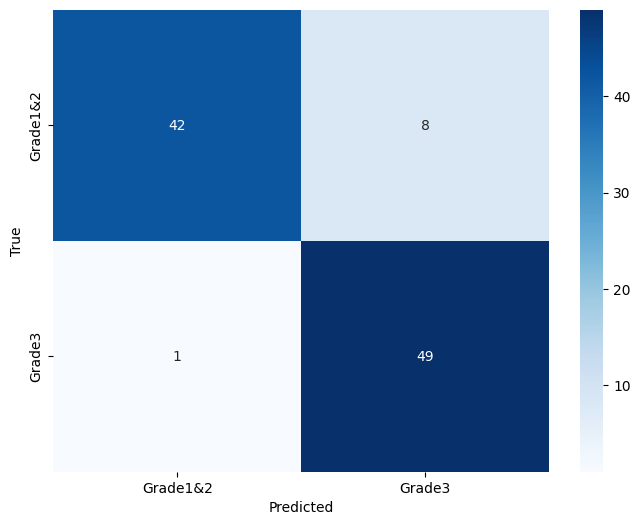

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')

# example
plt.xticks([0.5, 1.5], ['label1','label2'])
plt.yticks([0.5, 1.5], ['label1','label2'])

plt.savefig('Confusion_Matrix')

plt.show()

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_dataset.classes)
print('Classification Report:')
print(report)

y_true = np.array(y_true)
y_prob = np.array(y_probs)

C = confusion_matrix(y_true, y_pred)
ac = accuracy_score(y_true, y_pred)
pre = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
AUC = roc_auc_score(y_true, y_prob[:,1])

print(C)
print("\n")
print("test accuracy : %.3f" % ac)
print("test precision : %.3f" % pre)
print("test recall : %.3f" % re)
print("test F1 : %.3f" % f1)
print("AUC : %.3f" % AUC)

Classification Report:
                           precision    recall  f1-score   support

test_grade1and2_random_50       0.98      0.84      0.90        50
    test_grade3_random_50       0.86      0.98      0.92        50

                 accuracy                           0.91       100
                macro avg       0.92      0.91      0.91       100
             weighted avg       0.92      0.91      0.91       100

[[42  8]
 [ 1 49]]


test accuracy : 0.910
test precision : 0.918
test recall : 0.910
test F1 : 0.910
AUC : 0.976


In [ ]:
# example
save_path_list = [
    'best_model_1.pth',
    'best_model_2.pth',
    'best_model_3.pth',
    'best_model_4.pth',
    'best_model_5.pth',
]
def get_model(save_path):
    if 'resnet101' in save_path:
        model = models.resnet101(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)

    elif 'resnet152' in save_path:
        model = models.resnet152(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)

    elif 'efficientnet' in save_path:
        model = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = model._fc.in_features
        model._fc = nn.Linear(num_ftrs, 2)

    elif 'mobilenet_v2' in save_path:
        model = models.mobilenet_v2(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)

    elif 'mobilenet_v3_large' in save_path:
        model = models.mobilenet_v3_large(pretrained=True)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, 2)

    elif 'densenet169' in save_path:
        model = models.densenet169(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 2)

    elif 'densenet201' in save_path:
        model = models.densenet201(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 2)

    elif 'wide_resnet101_2' in save_path:
        model = models.wide_resnet101_2(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)

    else:
        raise ValueError(f"Unsupported model path: {save_path}")

    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threshold = 0.5

all_predictions = []
all_probabilities = []
y_true = []

for save_path in save_path_list:
    print(f"Evaluating model: {save_path}")

    model = get_model(save_path).to(device)
    model.load_state_dict(torch.load(save_path))
    model.eval()

    model_predictions = []
    model_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probabilities = nn.functional.softmax(outputs, dim=1)
            preds = (probabilities[:, 1] >= threshold).long()

            model_predictions.extend(preds.cpu().numpy())
            model_probabilities.extend(probabilities[:, 1].cpu().numpy())

            if len(y_true) == 0:
                y_true.extend(labels.cpu().numpy())

    all_predictions.append(model_predictions)
    all_probabilities.append(model_probabilities)

all_predictions = np.array(all_predictions)
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_predictions)

all_probabilities = np.array(all_probabilities)
final_probabilities = np.mean(all_probabilities, axis=0)

y_true = np.array(y_true)
C = confusion_matrix(y_true, final_predictions)
ac = accuracy_score(y_true, final_predictions)
pre = precision_score(y_true, final_predictions, average='macro')
re = recall_score(y_true, final_predictions, average='macro')
f1 = f1_score(y_true, final_predictions, average='macro')

AUC = roc_auc_score(y_true, final_probabilities)

print("Confusion Matrix:")
print(C)
print("\nMetrics:")
print(f"Accuracy: {ac:.3f}")
print(f"Precision: {pre:.3f}")
print(f"Recall: {re:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC: {AUC:.3f}")


Evaluating model: model_cnn_resnet101/Grade1and2vsGrade3_best_model.pth


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating model: model_cnn_efficientnet/Grade1and2vsGrade3_best_model.pth
Loaded pretrained weights for efficientnet-b0
Evaluating model: model_cnn_mobilenet_v2/Grade1and2vsGrade3_best_model.pth


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating model: model_cnn_mobilenet_v3_large/Grade1and2vsGrade3_best_model.pth


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating model: model_cnn_densenet169/Grade1and2vsGrade3_best_model.pth


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Confusion Matrix:
[[43  7]
 [ 2 48]]

Metrics:
Accuracy: 0.910
Precision: 0.914
Recall: 0.910
F1 Score: 0.910
AUC: 0.980


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models

data_transform = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=[-90, 90]),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

dataset = ImageFolder(root='train_folder', transform=data_transform['train'])
test_dataset = ImageFolder(root='test_folder', transform=data_transform['val'])

batch_size = 8
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# example
classes = ("label1", "label2")

# example
base_models = {
    "mobilenet_v2": models.mobilenet_v2(pretrained=True),
    "resnet101": models.resnet101(pretrained=True),
    "densenet169": models.densenet169(pretrained=True),
}
num_classes = 2
for name, model in base_models.items():
    if "resnet" in name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif "densenet" in name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif "mobilenet_v2" in name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for model in base_models.values():
    model.to(device)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

meta_features = []
meta_labels = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    fold_meta_features = []
    fold_meta_labels = [dataset.targets[idx] for idx in val_idx]

    for model_name, model in base_models.items():

        print(f"Training {model_name}...")

        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        num_epochs = 20
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = correct_predictions.double() / len(train_loader.dataset)

            print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()
        val_outputs = []
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                val_outputs.append(outputs.cpu().numpy())

        val_outputs = np.concatenate(val_outputs, axis=0)
        if len(val_outputs) != len(fold_meta_labels):
            raise ValueError(
                f"Model {model_name} output size ({len(val_outputs)}) does not match validation labels size ({len(fold_meta_labels)})"
            )
        fold_meta_features.append(val_outputs)

    fold_meta_features = np.concatenate(fold_meta_features, axis=1)
    meta_features.append(fold_meta_features)
    meta_labels.append(fold_meta_labels)

meta_features = np.concatenate(meta_features, axis=0)
meta_labels = np.concatenate(meta_labels)

meta_model = LogisticRegression()
meta_model.fit(meta_features, meta_labels)

meta_test_features = []
for model_name, model in base_models.items():
    model.eval()
    test_outputs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_outputs.append(outputs.cpu().numpy())

    test_outputs = np.concatenate(test_outputs, axis=0)
    meta_test_features.append(test_outputs)

meta_test_features = np.concatenate(meta_test_features, axis=1)
test_predictions = meta_model.predict(meta_test_features)

test_labels = [label for _, label in test_dataset]
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")


/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/fujimoto/anaconda3/envs/python_test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weigh

Fold 1
Training mobilenet_v2...
Training Loss: 0.6006 Acc: 0.7321
Training Loss: 0.4003 Acc: 0.7857
Training Loss: 0.3923 Acc: 0.8214
Training Loss: 0.2711 Acc: 0.8839
Training Loss: 0.3252 Acc: 0.8304
Training Loss: 0.3228 Acc: 0.8571
Training Loss: 0.2541 Acc: 0.9107
Training Loss: 0.3563 Acc: 0.8304
Training Loss: 0.2472 Acc: 0.8929
Training Loss: 0.1095 Acc: 0.9732
Training Loss: 0.1215 Acc: 0.9375
Training Loss: 0.2318 Acc: 0.9107
Training Loss: 0.1526 Acc: 0.9375
Training Loss: 0.1058 Acc: 0.9554
Training Loss: 0.1339 Acc: 0.9464
Training Loss: 0.2419 Acc: 0.9018
Training Loss: 0.1661 Acc: 0.9375
Training Loss: 0.1471 Acc: 0.9464
Training Loss: 0.2556 Acc: 0.8839
Training Loss: 0.2014 Acc: 0.9375
Training resnet101...
Training Loss: 0.4781 Acc: 0.7946
Training Loss: 0.3759 Acc: 0.8304
Training Loss: 0.3517 Acc: 0.8482
Training Loss: 0.3371 Acc: 0.8750
Training Loss: 0.3699 Acc: 0.8304
Training Loss: 0.2924 Acc: 0.8571
Training Loss: 0.3452 Acc: 0.8929
Training Loss: 0.3080 Acc: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=classes, digits=3))

conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

ac = accuracy_score(test_labels, test_predictions)
pre = precision_score(test_labels, test_predictions, average='macro')
re = recall_score(test_labels, test_predictions, average='macro')
f1 = f1_score(test_labels, test_predictions, average='macro')

print(f"Accuracy: {ac:.3f}")
print(f"Precision: {pre:.3f}")
print(f"Recall: {re:.3f}")
print(f"F1 Score: {f1:.3f}")

test_probabilities = meta_model.predict_proba(meta_test_features)
if len(classes) == 2:
    auc_score = roc_auc_score(test_labels, test_probabilities[:, 1])
else:
    auc_score = roc_auc_score(test_labels, test_probabilities, multi_class="ovr")
print(f"AUC Score: {auc_score:.3f}")

# example
meta_model_path = "meta_model.pkl"
joblib.dump(meta_model, meta_model_path)
print(f"Meta-model saved to {meta_model_path}")


Classification Report:
              precision    recall  f1-score   support

    Grade1&2      0.942     0.980     0.961        50
      Grade3      0.979     0.940     0.959        50

    accuracy                          0.960       100
   macro avg      0.961     0.960     0.960       100
weighted avg      0.961     0.960     0.960       100

Confusion Matrix:
[[49  1]
 [ 3 47]]
Accuracy: 0.960
Precision: 0.961
Recall: 0.960
F1 Score: 0.960
AUC Score: 0.989
Meta-model saved to meta_model_Grade1and2vsGrade3.pkl


In [ ]:
import os
import torch
import numpy as np
import joblib
import shutil

def classify_and_save_1st_stage(dataloader, dataset, output_dir="classified_data_1and2vs3"):
    grade1_2_dir = os.path.join(output_dir, "grade1_2")
    grade3_dir = os.path.join(output_dir, "grade3")

    os.makedirs(grade1_2_dir, exist_ok=True)
    os.makedirs(grade3_dir, exist_ok=True)

    meta_model_path = "meta_model.pkl"
    meta_model = joblib.load(meta_model_path)
    print(f"Loaded meta-model from {meta_model_path}")

    meta_test_features = []
    image_paths = [path for path, _ in dataset.samples]
    image_filenames = [os.path.basename(path) for path in image_paths]

    for model_name, model in base_models.items():
        model.eval()
        test_outputs = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                test_outputs.append(outputs.cpu().numpy())

        test_outputs = np.concatenate(test_outputs, axis=0)
        meta_test_features.append(test_outputs)

    meta_test_features = np.concatenate(meta_test_features, axis=1)
    preds = meta_model.predict(meta_test_features)
    print(preds)
    for img_path, pred in zip(image_paths, preds):
        folder = grade1_2_dir if pred == 0 else grade3_dir
        save_path = os.path.join(folder, os.path.basename(img_path))
        shutil.copy2(img_path, save_path)

    print("✅ 1st stage classification completed and images saved.")

    return preds, grade1_2_dir, grade3_dir


In [ ]:
preds_1st, grade1_2_dir, grade3_dir = classify_and_save_1st_stage(test_loader, test_dataset)

Loaded meta-model from meta_model_Grade1and2vsGrade3.pkl
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
✅ 1st stage classification completed and images saved.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def load_model(model_path, model_type):
    if model_type == "resnet101":
        model = models.resnet101(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_type == "densenet169":
        model = models.densenet169(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def classify_and_save_2st_stage(output_dir="classified_data_1and2vs3", threshold=0.5, batch_size=8):
    test_dataset_2nd_stage = ImageFolder(root='classified_data_1and2vs3/test_1vs2', transform=data_transform['val'])
    test_loader_2nd_stage  = DataLoader(test_dataset_2nd_stage, batch_size=batch_size, shuffle=False)
    print(len(test_dataset_2nd_stage))

    grade1_dir = os.path.join(output_dir, "grade1")
    grade2_dir = os.path.join(output_dir, "grade2")

    os.makedirs(grade1_dir, exist_ok=True)
    os.makedirs(grade2_dir, exist_ok=True)

    image_filenames = [os.path.basename(path) for path, _ in test_dataset_2nd_stage.samples]

    # example
    model_2nd = load_model("model_cnn_densenet169/best_model.pth", "densenet169")

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader_2nd_stage:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_2nd(inputs)
            probabilities = nn.functional.softmax(outputs, dim=1)
            preds = (probabilities[:, 1] >= threshold).long()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            probabilities = nn.functional.softmax(outputs, dim=1)
            y_probs.extend(probabilities.cpu().numpy())

    preds_batches = [y_pred[i:i + batch_size] for i in range(0, len(y_pred), batch_size)]
    image_filenames_batches = [image_filenames[i:i + batch_size] for i in range(0, len(image_filenames), batch_size)]
    image_paths = [path for path, _ in test_dataset_2nd_stage.samples]

    print(y_pred)
    print(preds_batches)
    for img_path, pred in zip(image_paths, y_pred):
        folder = grade1_dir if pred == 0 else grade2_dir
        save_path = os.path.join(folder, os.path.basename(img_path))
        shutil.copy2(img_path, save_path)

    print("✅ 2nd stage classification completed and images saved.")

    return y_pred

In [ ]:
preds_2nd = classify_and_save_2st_stage()

44
[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[[0, 0, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1, 1, 0, 1], [0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0]]
✅ 2nd stage classification completed and images saved.


In [ ]:
# example
y_true = []
for i in range(18):
    y_true.append(0)
for i in range(20):
    y_true.append(1)
for i in range(20):
    y_true.append(2)
print(y_true)
final_predictions =  [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
final_predictions += [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2]
final_predictions += [0,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]

C = confusion_matrix(y_true, final_predictions)
ac = accuracy_score(y_true, final_predictions)
pre = precision_score(y_true, final_predictions, average='macro')
re = recall_score(y_true, final_predictions, average='macro')
f1 = f1_score(y_true, final_predictions, average='macro')

print(y_true)
print(final_predictions)
print("Confusion Matrix:")
print(C)
print("\nMetrics:")
print(f"Accuracy: {ac:.3f}")
print(f"Precision: {pre:.3f}")
print(f"Recall: {re:.3f}")
print(f"F1 Score: {f1:.3f}")


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Confusion Matrix:
[[12  6  0]
 [ 1 18  1]
 [ 1  2 17]]

Metrics:
Accuracy: 0.810
Precision: 0.831
Recall: 0.806
F1 Score: 0.809


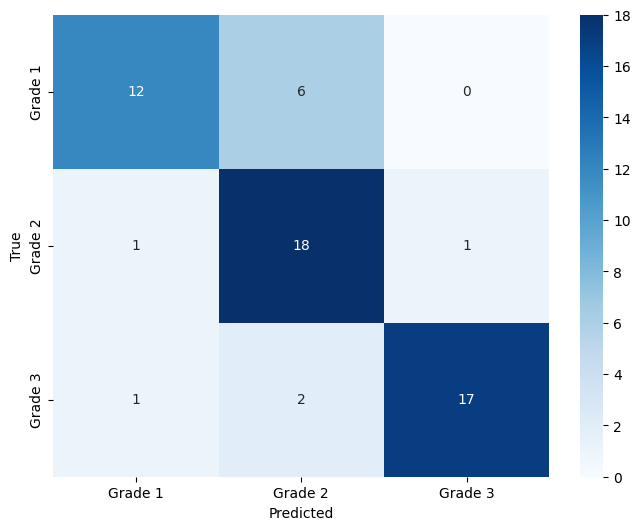

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(C, annot=True, fmt="d", cmap="Blues", xticklabels=["Grade 1", "Grade 2", "Grade 3"], yticklabels=["Grade 1", "Grade 2", "Grade 3"])

plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('confusion_matrix')

plt.show()
